#Case


## Instructions

In order to run this notebook on colab, please follow the instructions:
1. In your google drive storage, create a directory and upload the case.xlsx there.
2. Set the variable `your_directory` (two cells below) to the name of the folder you just created.

## Set-up

In [1]:
!pip install catboost
!pip install rdkit
!pip install transformers
!pip install datasets
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

Connect to Google Drive

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Change the name of the directory and execute the cell

In [3]:
your_directory = 'ValenceLabs'
os.chdir('/content/drive/My Drive/use_cases/' + your_directory)

Imports

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from warnings import filterwarnings
import time


from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator


Some utilities

In [5]:
# Matplotlib env
def set_plot_env():
    mpl.rcdefaults()
    mpl.rcParams['mathtext.default']= 'regular'
    mpl.rcParams['font.size'] = 18.
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.weight'] = "normal"
    mpl.rcParams['axes.labelsize'] = 18.
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18

    mpl.rcParams['xtick.major.width'] = 0.6
    mpl.rcParams['ytick.major.width'] = 0.6
    mpl.rcParams['axes.linewidth'] = 0.6
    mpl.rcParams['pdf.fonttype'] = 3

    mpl.rcParams["xtick.minor.visible"] = "on"
    mpl.rcParams["xtick.direction"] = "in"
    mpl.rcParams["xtick.top"] = "on"
    mpl.rcParams["xtick.major.size"] = 8
    mpl.rcParams["xtick.minor.size"] = 5

    mpl.rcParams["ytick.minor.visible"] = "on"
    mpl.rcParams["ytick.direction"] = "in"
    mpl.rcParams["ytick.major.size"] = 8
    mpl.rcParams["ytick.minor.size"] = 5
    mpl.rcParams["ytick.right"] = "on"



def plot_figures(x, y_arr, label_arr, x_axis, y_axis, fig_name, save_dir = '.', n = 100):
    # ====================
    # Plotting the results
    # ====================
    set_plot_env()
    fig , axes = plt.subplots(1,1,figsize=(10,7))
    fig.subplots_adjust(left=0.18, right=.9, bottom=0.15, top=0.9);
    axes.set_xlabel(x_axis)
    axes.set_ylabel(y_axis)

    xx, = axes.plot(x[::n], y_arr[0][::n], color = 'darkorange', marker='o', lw = 1.5, label=label_arr[0])
    yy, = axes.plot(x[::n], y_arr[1][::n], color = 'darkblue', marker='o', lw = 1.5,  label=label_arr[1])
    leg1 = axes.legend(loc='best')
    axes.add_artist(leg1)
    fig.savefig(save_dir + '/' + fig_name + '.jpg')
    plt.show()
    plt.clf()

## Data exploration

We re-format the data to make it easier to handle.

In [2]:
df = pd.read_csv('./data/EGFR_compounds_lipinski.csv')
to_delete = ['Unnamed: 0', 'ro5_fulfilled', 'molecule_chembl_id', 'units']
df = df.drop(to_delete, axis=1)
df['label'] = np.where(df['pIC50'] > 8.0, 1.0, 0.0)
df

NameError: ignored

In [45]:
len(df[df.label==True])

873

In [46]:
len(df[df.label==False])

3762

Here we get some statistics on the data

In [25]:
df.describe()

,IC50,pIC50,molecular_weight,n_hba,n_hbd,logp
count,4.635000e+03,4635.000000,4635.000000,4635.000000,4635.000000,4635.000000
mean,2.426576e+04,6.608090,414.439011,5.996548,1.889968,4.070568
std,4.028311e+05,1.429006,87.985100,1.875491,1.008368,1.193034
min,3.000000e-03,1.602060,110.036779,0.000000,0.000000,-5.994500
25%,2.000000e+01,5.475628,354.079275,5.000000,1.000000,3.428700
50%,2.500000e+02,6.602060,419.195740,6.000000,2.000000,4.151000
75%,3.345000e+03,7.698970,476.159399,7.000000,2.000000,4.794750
max,2.500000e+07,11.522879,704.185617,11.000000,8.000000,8.782600


In [10]:
df.info()
view = df.loc[:, df.columns.isin(['n_hba', 	'n_hbd', 	'logp', 'pIC50'])]
view

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IC50              4635 non-null   float64
 1   smiles            4635 non-null   object 
 2   pIC50             4635 non-null   float64
 3   molecular_weight  4635 non-null   float64
 4   n_hba             4635 non-null   int64  
 5   n_hbd             4635 non-null   int64  
 6   logp              4635 non-null   float64
 7   label             4635 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(1)
memory usage: 258.1+ KB


,pIC50,n_hba,n_hbd,logp
0,11.522879,3,1,5.28910
1,11.221849,5,1,4.93330
2,11.221849,5,1,3.59690
3,11.096910,4,2,4.01220
4,11.096910,5,2,3.57260
...,...,...,...,...
4630,2.585027,4,1,2.13978
4631,2.522879,2,2,1.49000
4632,2.301030,6,1,5.20048
4633,2.187087,3,1,1.59806


## Boxplots

We visualize boxplots to see if we have outliers

<ipython-input-11-0402680a76da>:10: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)


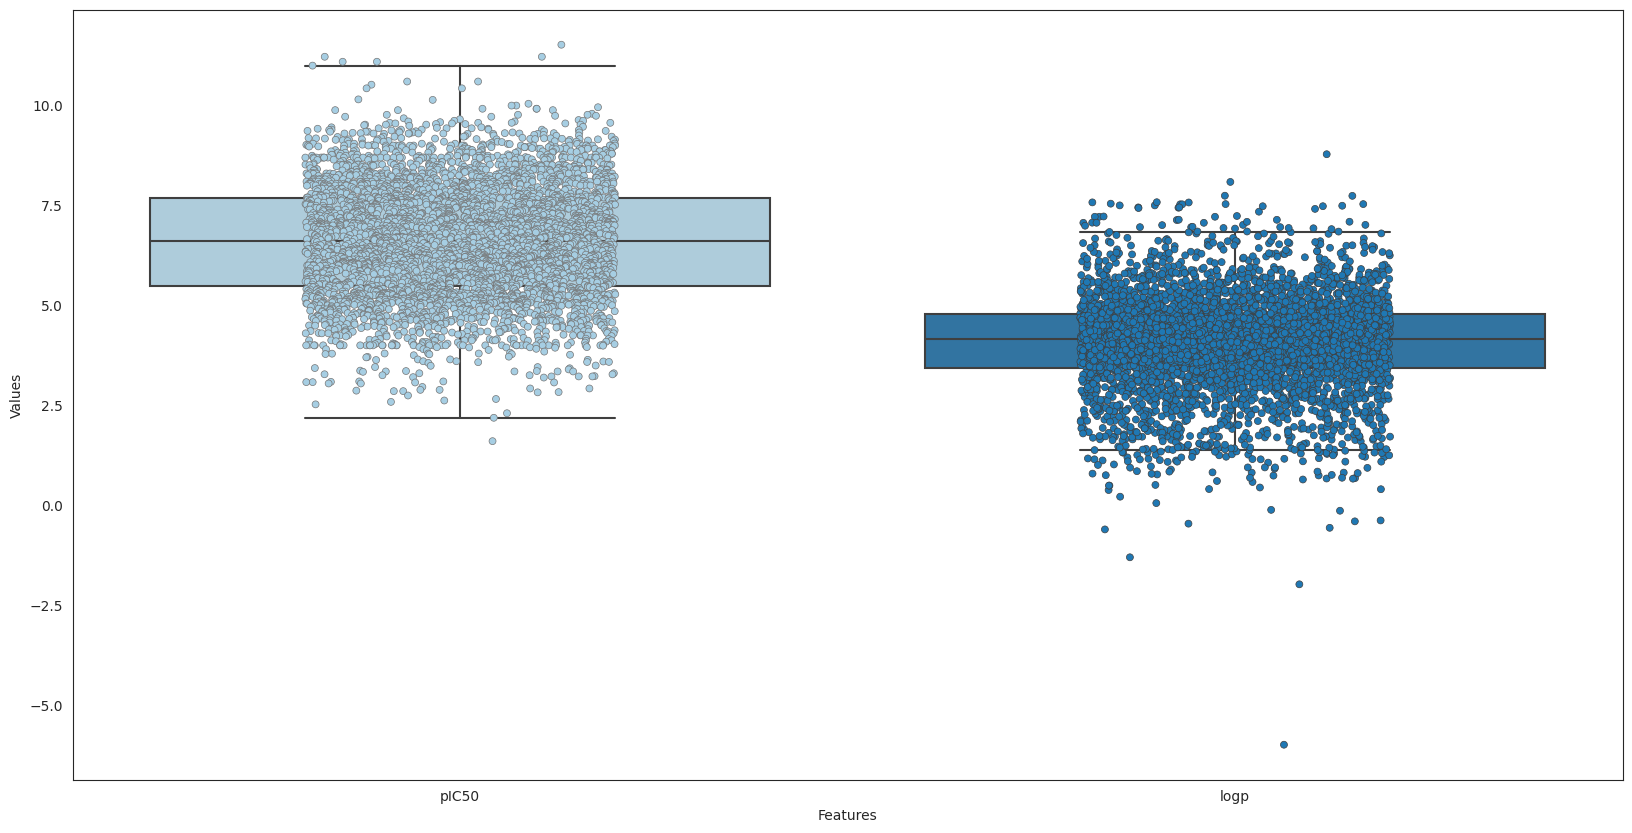

In [11]:
#view = df.loc[:, ~df.columns.isin(['smiles', 'label'])]
view = df.loc[:, df.columns.isin(['logp', 'pIC50'])]
#view = df.loc[:, df.columns.isin(['IC50','molecular_weight'])]

sns.set_style('white')
pal = sns.color_palette('Paired')
fig, ax = plt.subplots(sharex=True, figsize=(20,10))
ax.set(xlabel="Features", ylabel = "Values")
sns.boxplot(data=view, ax=ax, fliersize=0, palette=pal)
sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)
plt.rcParams.update({'font.size': 22})
plt.savefig('boxplot1.jpg')

<ipython-input-12-5cbd807ec8f9>:8: UserWarning: The palette list has more values (12) than needed (1), which may not be intended.
  sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)


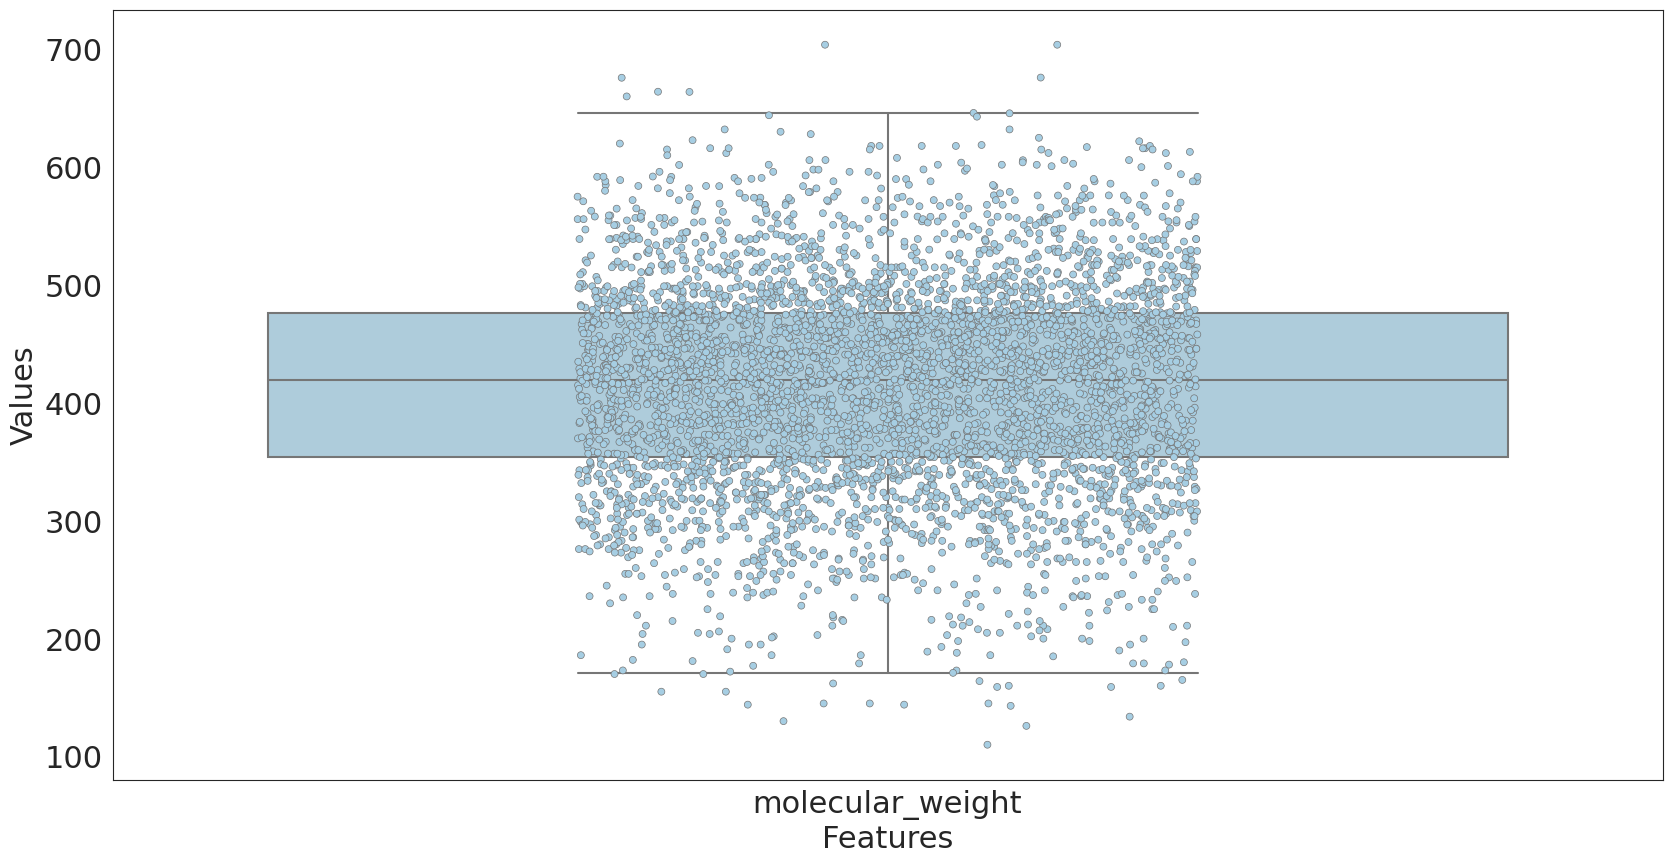

In [12]:
view = df.loc[:, df.columns.isin(['molecular_weight'])]
sns.set_style('white')
pal = sns.color_palette('Paired')
fig, ax = plt.subplots(sharex=True, figsize=(20,10))
ax.set(xlabel="Features", ylabel = "Values")
sns.boxplot(data=view, ax=ax, fliersize=0, palette=pal)
sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)
plt.rcParams.update({'font.size': 22})
plt.savefig('boxplot2.jpg')

<ipython-input-13-2a1f7c383a68>:8: UserWarning: The palette list has more values (12) than needed (1), which may not be intended.
  sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)


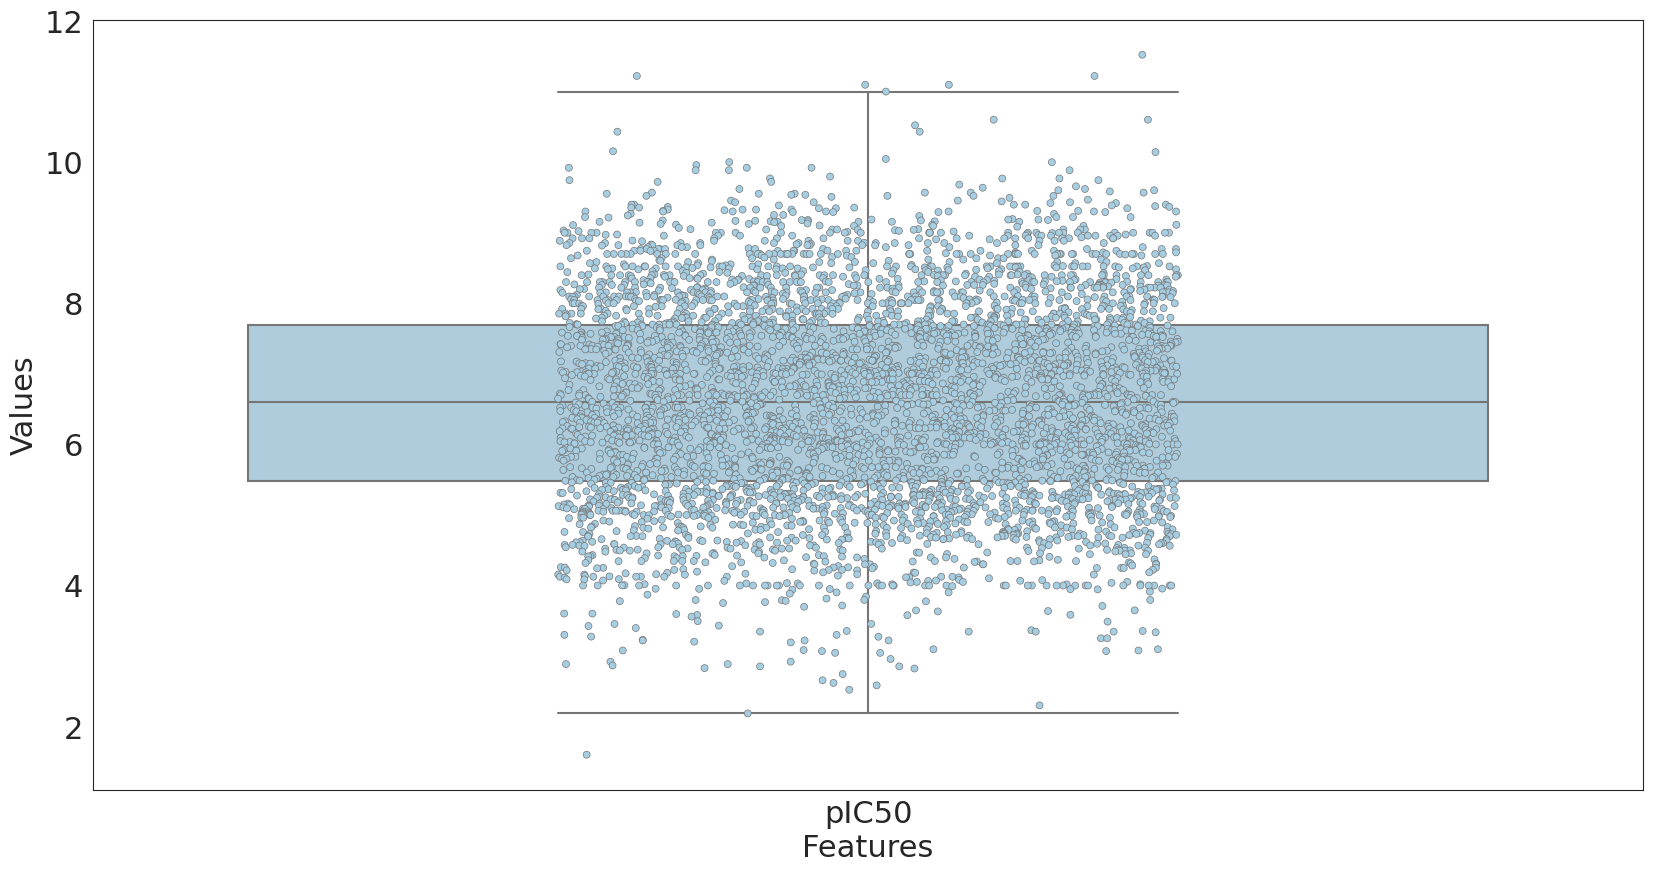

In [13]:
view = df.loc[:, df.columns.isin(['pIC50'])]
sns.set_style('white')
pal = sns.color_palette('Paired')
fig, ax = plt.subplots(sharex=True, figsize=(20,10))
ax.set(xlabel="Features", ylabel = "Values")
sns.boxplot(data=view, ax=ax, fliersize=0, palette=pal)
sns.stripplot(data=view, ax=ax, jitter=0.2, linewidth=0.5, palette=pal)
plt.rcParams.update({'font.size': 22})
plt.savefig('boxplot3.jpg')

## Correlations

We want to see whether some features are correlated or not (so we can reduce the dimensionality).

Pearson correlation

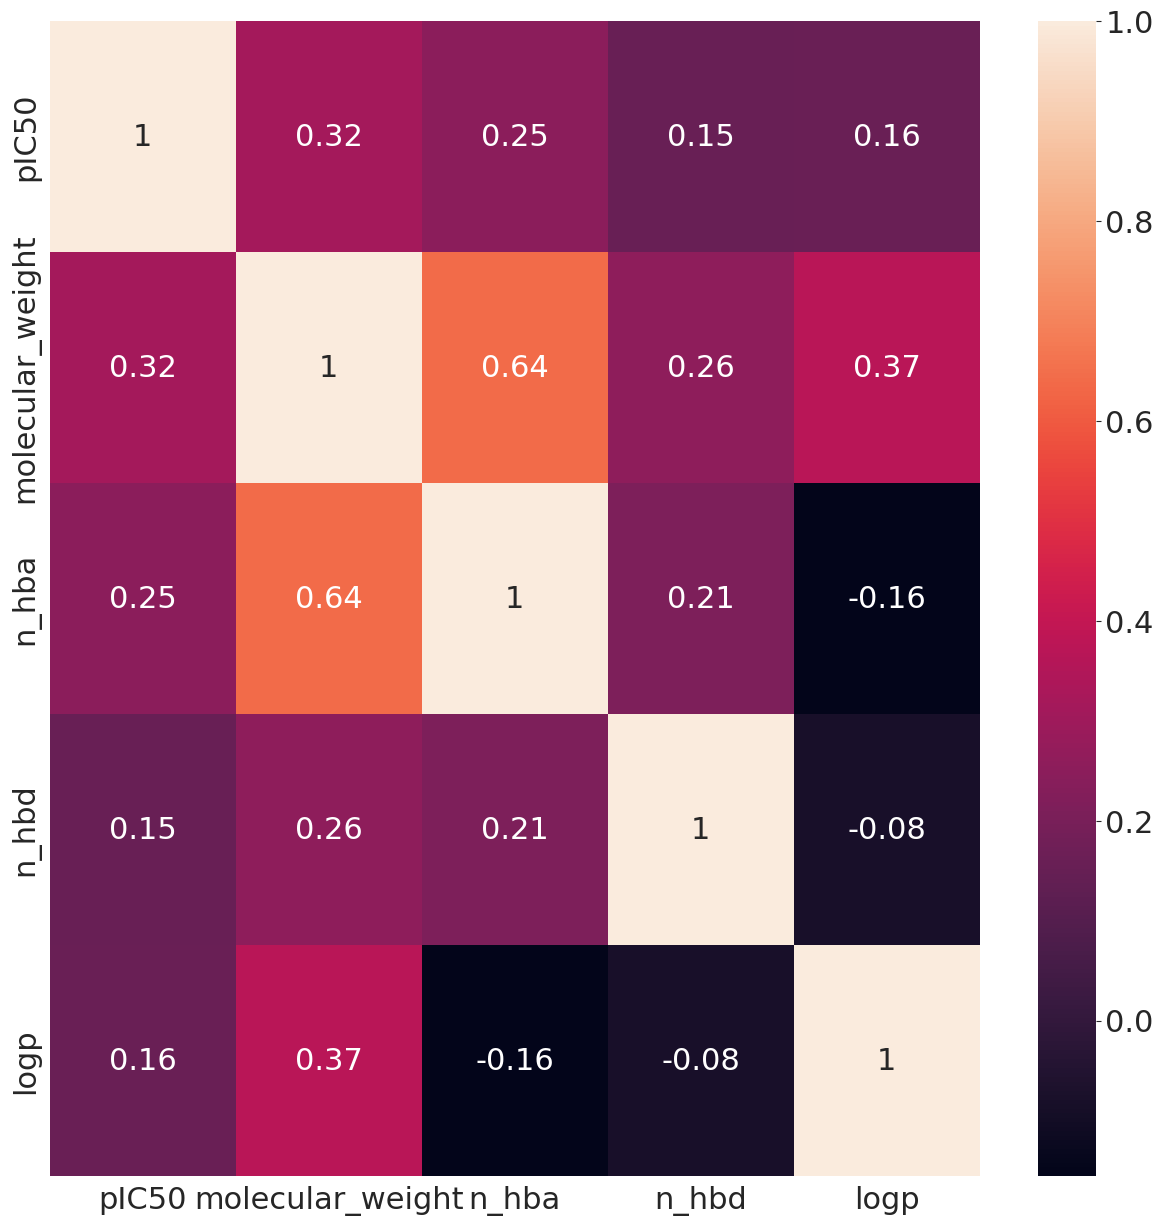

In [15]:
fig, ax = plt.subplots(sharex=True, figsize=(15,15))
view = df.loc[:, ~df.columns.isin(['smiles', 'label', 'IC50'])]
corr = view.corr(method = 'spearman')
sns.heatmap(corr, annot = True)
fig.savefig('spearman.jpg')

## Data preprocessing

We use this function to convert numpy arrays to lists. This is necessary for our first model.

In [6]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc


def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

def tokenize_smiles(smile_token):
  inputs = tokenizer1.encode_plus(smile_token, return_tensors='pt', add_special_tokens=True)
  print(inputs)
  #input_ids = inputs['input_ids']
  #attention = model(input_ids)[-1]
  return inputs


def prepare_dataset(path='./data/EGFR_compounds_lipinski.csv', featurize=False, tokenize=False, tokenizer=None):
  df = pd.read_csv(path)
  to_delete = ['Unnamed: 0', 'ro5_fulfilled', 'molecule_chembl_id', 'units']
  df = df.drop(to_delete, axis=1)
  df['labels'] = np.where(df['pIC50'] > 8.0, 1.0, 0.0)
  if featurize:
    df["smiles_fp"] = df["smiles"].apply(smiles_to_fp)
  if tokenize:
    if not tokenizer:
      raise ValueError("Variable 'tokenizer' should be set when parameter 'tokenize' is True.")
    df["smiles_tok"] = df["smiles"].apply(tokenize_smiles)
  return df

def split_dataset(df, lbl_name="label", train_size=0.8, seed=42):
  df_train, df_eval = train_test_split(df, shuffle=True, stratify=df[lbl_name], test_size=(1.0 - train_size), random_state=seed)
  return(df_train, df_eval)


In [11]:
SEED = 33
feats = df[['smiles_fp','molecular_weight','n_hba','n_hbd','logp']].values.tolist()
labels = df.label.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    train_x,
    test_x,
    train_y,
    test_y,
) = train_test_split(feats, labels, test_size=0.2, random_state=SEED, stratify=labels)

# NBVAL_CHECK_OUTPUT
print("Training data size:", len(train_x))
print("Test data size:", len(test_x))
train_x[0]

Training data size: 3708
Test data size: 927


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 333.068032556,
 5,
 1,
 4.183100000000002]

## First Model: CATBOOST

Gradient boosting algorithms have become bread and butter in lots of real-world problems. CatBoost is one of the latest members in the family of gradient boosting toolkit. We have picked that one as it has the flexibility to handle mix of categorical and numerical data.

1.  We are going to perform this test with all the features (no dimensionality reduction). It is important to have an idea of the performance, as well as the importance of features.

In [21]:

# Initialize CatBoostClassifier
#model = CatBoostClassifier(iterations=2000, learning_rate=0.009, depth=10, task_type="GPU", devices='0')
# params = {'iterations': 20000, 'learning_rate': 0.009861006280904538, 'depth': 7, 'subsample': 0.5907102350969746, 'colsample_bylevel': 0.3748027986231955, 'min_data_in_leaf': 57}
# params =  {'iterations': 6000, 'learning_rate': 0.08679716060150285, 'depth': 11, 'subsample': 0.08891930017791809, 'colsample_bylevel': 0.5898262004884961, 'min_data_in_leaf': 36}
params = {
  "iterations": 300,
  "learning_rate": random.uniform(1e-3, 0.1),
  "depth": random.randint(4, 16),
  "subsample": random.uniform(0.05, 1.0),
  "colsample_bylevel": random.uniform(0.05, 1.0),
  "min_data_in_leaf": random.randint(1, 100),
}
params =  {'iterations': 300,
           'learning_rate': 0.08679716060150285,
           'depth': 11,
           'subsample': 0.08891930017791809,
           'colsample_bylevel': 0.5898262004884961,
           'min_data_in_leaf': 47
           }

model = CatBoostClassifier(**params)

# Fit model
model.fit(train_x, train_y, embedding_features=[0], eval_set=(test_x, test_y))

# Get predictions
model_performance(model, test_x, test_y, verbose=True)

0:	learn: 0.6168495	test: 0.6198874	best: 0.6198874 (0)	total: 12.7ms	remaining: 3.79s
1:	learn: 0.5615018	test: 0.5657509	best: 0.5657509 (1)	total: 32.6ms	remaining: 4.85s
2:	learn: 0.5125201	test: 0.5184040	best: 0.5184040 (2)	total: 45.1ms	remaining: 4.47s
3:	learn: 0.4906882	test: 0.4968051	best: 0.4968051 (3)	total: 46.6ms	remaining: 3.45s
4:	learn: 0.4572811	test: 0.4660837	best: 0.4660837 (4)	total: 61.6ms	remaining: 3.63s
5:	learn: 0.4333038	test: 0.4456565	best: 0.4456565 (5)	total: 80.7ms	remaining: 3.96s
6:	learn: 0.4125661	test: 0.4304108	best: 0.4304108 (6)	total: 108ms	remaining: 4.51s
7:	learn: 0.3979096	test: 0.4182831	best: 0.4182831 (7)	total: 130ms	remaining: 4.74s
8:	learn: 0.3858428	test: 0.4067756	best: 0.4067756 (8)	total: 150ms	remaining: 4.84s
9:	learn: 0.3726673	test: 0.3991331	best: 0.3991331 (9)	total: 164ms	remaining: 4.74s
10:	learn: 0.3629808	test: 0.3927854	best: 0.3927854 (10)	total: 177ms	remaining: 4.64s
11:	learn: 0.3556624	test: 0.3876962	best: 0.3

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Sensitivity: 0.36
Specificity: 0.95
AUC: 0.84


(0.837108953613808, 0.36, 0.9481382978723404, 0.8378229483282674)

In [27]:


# Initialize CatBoostClassifier
params =  {'iterations': 90, 'learning_rate': 0.08679716060150285, 'depth': 11, 'subsample': 0.08891930017791809, 'colsample_bylevel': 0.5898262004884961, 'min_data_in_leaf': 47}
model = CatBoostClassifier(**params)

# Fit model
model.fit(np.array(train_x)[:,0].tolist() , train_y, eval_set=(np.array(test_x)[:,0].tolist(), test_y))

# Get predictions
preds = model.predict( np.array(test_x)[:,0].tolist())

model_performance(model, np.array(test_x)[:,0].tolist(), test_y, verbose=True)

<ipython-input-27-e8e6078f03d1>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model.fit(np.array(train_x)[:,0].tolist() , train_y, eval_set=(np.array(test_x)[:,0].tolist(), test_y))


0:	learn: 0.6322327	test: 0.6381584	best: 0.6381584 (0)	total: 527ms	remaining: 46.9s
1:	learn: 0.5857959	test: 0.5982882	best: 0.5982882 (1)	total: 1.14s	remaining: 50s
2:	learn: 0.5442074	test: 0.5624523	best: 0.5624523 (2)	total: 1.72s	remaining: 49.9s
3:	learn: 0.5096398	test: 0.5337712	best: 0.5337712 (3)	total: 2.33s	remaining: 50s
4:	learn: 0.4794738	test: 0.5090848	best: 0.5090848 (4)	total: 2.71s	remaining: 46.1s
5:	learn: 0.4554870	test: 0.4869588	best: 0.4869588 (5)	total: 3.13s	remaining: 43.8s
6:	learn: 0.4343047	test: 0.4695443	best: 0.4695443 (6)	total: 3.53s	remaining: 41.9s
7:	learn: 0.4139742	test: 0.4533621	best: 0.4533621 (7)	total: 3.97s	remaining: 40.7s
8:	learn: 0.3973958	test: 0.4411471	best: 0.4411471 (8)	total: 4.37s	remaining: 39.4s
9:	learn: 0.3837549	test: 0.4319778	best: 0.4319778 (9)	total: 4.77s	remaining: 38.1s
10:	learn: 0.3700574	test: 0.4217283	best: 0.4217283 (10)	total: 5.17s	remaining: 37.1s
11:	learn: 0.3608408	test: 0.4145144	best: 0.4145144 (11

<ipython-input-27-e8e6078f03d1>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = model.predict( np.array(test_x)[:,0].tolist())
<ipython-input-27-e8e6078f03d1>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_performance(model, np.array(test_x)[:,0].tolist(), test_y, verbose=True)


(0.8446601941747572,
 0.4228571428571429,
 0.9428191489361702,
 0.8702469604863221)

(0.7982740021574973,
 0.3485714285714286,
 0.9029255319148937,
 0.7959270516717325)

In [65]:
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)
model_RF.fit(np.array(train_x)[:,0].tolist(), train_y)

# Get predictions
#preds = model_RF.predict(test_x)

model_performance(model_RF, np.array(test_x)[:,0].tolist(), test_y, verbose=True)

<ipython-input-65-17be38216aba>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_RF.fit(np.array(train_x)[:,0].tolist(), train_y)


Sensitivity: 0.47
Specificity: 0.93
AUC: 0.87


<ipython-input-65-17be38216aba>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model_performance(model_RF, np.array(test_x)[:,0].tolist(), test_y, verbose=True)


(0.8468176914778857,
 0.4742857142857143,
 0.9335106382978723,
 0.8654483282674773)

In [61]:
np.array(train_x)[:,0].tolist()

<ipython-input-61-5f3c62b0a780>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_x)[:,0].tolist()


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1

In [31]:
from transformers import AutoModelWithLMHead, AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset

#any model weights from the link above will work here
model1 = AutoModelWithLMHead.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer1 = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1",use_fast=True)

# load model and tokenizer and define length of the text sequence
model2 = AutoModelForSequenceClassification.from_pretrained('seyonec/PubChem10M_SMILES_BPE_396_250')
tokenizer2 = AutoTokenizer.from_pretrained('seyonec/PubChem10M_SMILES_BPE_396_250',use_fast=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1479: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

NameError: ignored

In [36]:
df["smiles_tok"][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [40]:
model2(torch.tensor([df["smiles_tok"][0]]))

SequenceClassifierOutput(loss=None, logits=tensor([[0.0118, 0.4119]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [42]:
dataset = Dataset.from_pandas(df)

In [43]:
dataset

Dataset({
    features: ['IC50', 'smiles', 'pIC50', 'molecular_weight', 'n_hba', 'n_hbd', 'logp', 'label', 'smiles_fp', 'smiles_tok'],
    num_rows: 4635
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer1)

train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=args.per_device_train_batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=args.per_device_eval_batch_size)


In [14]:
#from simpletransformers.classification import ClassificationModel, ClassificationArgs

#df = prepare_dataset(path='./data/EGFR_compounds_lipinski.csv')
#df = df.rename(columns={"smiles": "text"})
#df_train, df_eval = split_dataset(df, lbl_name="labels", train_size=0.8, seed=42)

#model = ClassificationModel('roberta', 'seyonec/SMILES_tokenized_PubChem_shard00_160k', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 15, 'auto_weights': True})
model.train_model(df_train, eval_df=df_eval, num_labels=2, use_cuda=True, output_dir='./output-2/', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 5, 'auto_weights': True})


  0%|          | 0/3708 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/464 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/464 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/464 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/464 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/464 [00:00<?, ?it/s]

(2320, 0.12376722974124654)

In [17]:
import sklearn
result, _, wrong_predictions_1 = model.eval_model(df_eval, acc=sklearn.metrics.accuracy_score)
result

  0%|          | 0/927 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/116 [00:00<?, ?it/s]

{'mcc': 0.5318185066384082,
 'tp': 102,
 'tn': 697,
 'fp': 55,
 'fn': 73,
 'auroc': 0.8722910334346505,
 'auprc': 0.6561889233517438,
 'acc': 0.8619201725997843,
 'eval_loss': 0.8990149862441066}

In [18]:
# ROC-PRC
result, _, wrong_predictions_2 = model.eval_model(df_eval, acc=sklearn.metrics.average_precision_score)
result

  0%|          | 0/927 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/116 [00:00<?, ?it/s]

{'mcc': 0.5318185066384082,
 'tp': 102,
 'tn': 697,
 'fp': 55,
 'fn': 73,
 'auroc': 0.8722910334346505,
 'auprc': 0.6561889233517438,
 'acc': 0.45742017112742483,
 'eval_loss': 0.8990149862441066}

In [19]:
# ROC-PRC
result, _, wrong_predictions_2 = model.eval_model(df_eval, acc=sklearn.metrics.average_precision_score)
result

[{'guid': 11, 'text_a': 'CN1CCN(C(=O)Nc2cc3c(Nc4ccc(F)c(Cl)c4)ncnc3cc2O[C@H]2CCOC2)CC1', 'text_b': None, 'label': 0.0},
 {'guid': 13, 'text_a': 'COc1cc2ncnc(N3CCCc4ccccc43)c2cc1NC(=O)/C=C/CN(C)C', 'text_b': None, 'label': 0.0},
 {'guid': 17, 'text_a': 'C=C=CCCCCOc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O', 'text_b': None, 'label': 0.0},
 {'guid': 20, 'text_a': 'O=C(CCCCCCn1cc(-c2ccc3ncnc(Nc4ccc(F)c(Cl)c4)c3c2)nn1)NO', 'text_b': None, 'label': 1.0},
 {'guid': 21, 'text_a': 'OCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 'text_b': None, 'label': 1.0},
 {'guid': 25, 'text_a': 'COc1cc2ncnc(Nc3ccc(Br)cc3)c2cc1OC', 'text_b': None, 'label': 1.0},
 {'guid': 29, 'text_a': 'C=CC(=O)N1CCC[C@@H]1Cn1nc(-c2ccc(Oc3ccccc3)cc2)c2c(N)ncnc21', 'text_b': None, 'label': 0.0},
 {'guid': 30, 'text_a': 'O=C(/C=C/CN1CC2(COC2)C1)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2s1', 'text_b': None, 'label': 1.0},
 {'guid': 43, 'text_a': 'C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cc1OCC', 'text_b': None, 'label': 1.0},
 {'guid'